<a href="https://colab.research.google.com/github/Kashara-Alvin-Ssali/ML-models/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:

# Install required libraries
!pip install opencv-python numpy scikit-learn

import os
import zipfile
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [31]:
# Mount Google Drive
from google.colab import drive # Added this line to import the drive module
drive.mount('/content/drive')

# Define dataset paths
drive_path = "/content/drive/My Drive/Dataset.zip"  # Update path if needed
zip_path = "/content/Dataset.zip"  # Destination in Colab
extract_path = "/content/Dataset"

# Check if the zip file exists and extract
if not os.path.exists(zip_path):
    # Copy the zip file from Google Drive to Colab
    !cp "{drive_path}" "{zip_path}"  # Use !cp to copy files in Colab
    print(f"Copied '{drive_path}' to '{zip_path}'")

    # Extract the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extracted '{zip_path}' to '{extract_path}'")
else:
    print(f"'{zip_path}' already exists, skipping extraction.")
# %%
# Define paths
train_dir = "/content/Dataset/Dataset/Training" # Modified the path
val_dir = "/content/Dataset/Dataset/Validation" # Modified the path
test_dir = "/content/Dataset/Dataset/Testing" # Modified the path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'/content/Dataset.zip' already exists, skipping extraction.


In [32]:
# Check for duplicate images between train and test sets
train_images = set(os.listdir(train_dir))
test_images = set(os.listdir(test_dir))

common_images = train_images.intersection(test_images)
print(f"Common images between train and test sets: {len(common_images)}")


Common images between train and test sets: 2


In [33]:
# Function to extract features from images
def extract_features(image_path):
    img = cv2.imread(image_path)

    # Convert image to HSV and compute histograms
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_hist = cv2.calcHist([hsv_img], [0], None, [256], [0, 256]).flatten()
    s_hist = cv2.calcHist([hsv_img], [1], None, [256], [0, 256]).flatten()
    v_hist = cv2.calcHist([hsv_img], [2], None, [256], [0, 256]).flatten()

    # Edge detection using Canny
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_img, 100, 200)

    edges = cv2.resize(edges, (128, 128)).flatten()

    # Combine all features into a single vector
    feature_vector = np.hstack([h_hist, s_hist, v_hist, edges])

    return feature_vector

In [34]:
# Function to load dataset and extract features
def load_dataset(directory):
    features = []
    labels = []

    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)

        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                feature_vector = extract_features(img_path)
                features.append(feature_vector)
                labels.append(0 if label == "real" else 1)  # 0 for real, 1 for fake

    return np.array(features), np.array(labels)

In [35]:
# Load training and test data
print("Extracting features from training set...")
X_train, y_train = load_dataset(train_dir)

print("Extracting features from test set...")
X_test, y_test = load_dataset(test_dir)

Extracting features from training set...
Extracting features from test set...


In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
# Train KNN model
knn = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean')
  # Adjust n_neighbors for tuning
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=7, weights='distance')

In [38]:
# Evaluate KNN
accuracy = knn.score(X_test, y_test)
print(f"KNN Test Accuracy: {accuracy * 100:.2f}%")

KNN Test Accuracy: 66.60%


In [39]:
# Function to predict a single image
def predict_with_knn(image_path, knn_model, scaler):
    # Load the image and check if it was loaded successfully
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}. Please check the path.")
        return None  # Or handle the error in another way

    feature_vector = extract_features(image_path).reshape(1, -1)
    feature_vector = scaler.transform(feature_vector)
    prediction = knn_model.predict(feature_vector)
    return 'Real' if prediction[0] == 0 else 'Fake'

In [40]:
# Test with a sample image
test_image_path = "/content/Dataset/Dataset/Testing/Real/Real1.jpg"  # Change to an actual test image path
knn_result = predict_with_knn(test_image_path, knn, scaler)
print(f'KNN Prediction: {knn_result}')

KNN Prediction: Fake


In [41]:
!pip install seaborn

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


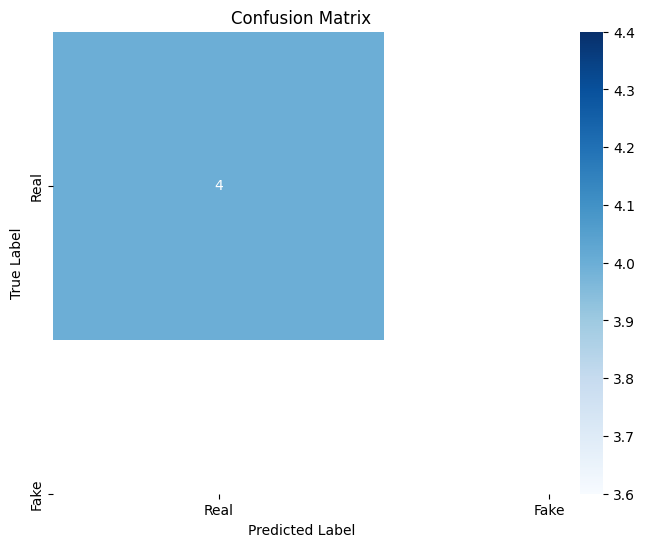

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


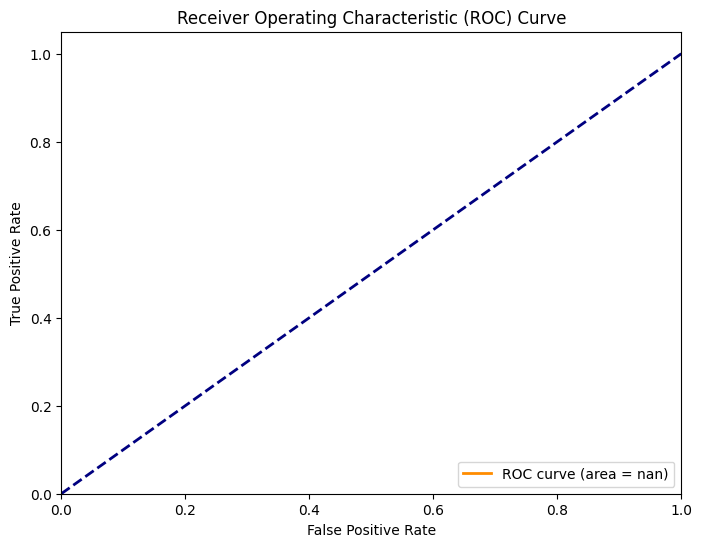

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix # Import confusion_matrix

# ... (previous code for training and prediction)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, knn.predict(X_test)) # Calculate and assign to conf_matrix

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ... (rest of the code)
from sklearn.metrics import roc_curve, auc

# ... (previous code for training and prediction)

# Get probabilities for ROC curve
# Get probabilities for ROC curve
y_probs = knn.predict_proba(X_test)[:, 0]  # Probability of class 0 (Real) if only one class is present
# if more than one class
#y_probs = knn.predict_proba(X_test)[:, 1]  # Probability of class 1 (Fake)  # Probability of class 1 (Fake)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()